In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random



from matplotlib.ticker import FuncFormatter

import pickle




time_1 = datetime.datetime.now()
warnings.filterwarnings('ignore')

plt.rcParams["font.family"]='Arial Unicode MS'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['figure.figsize'] = (18,8)   
plt.rcParams['figure.dpi'] = 300.0  # 分辨率
plt.rcParams['savefig.dpi'] = 300.0  # 图片像素

harvest_red = '#a50000'
harvest_gray = '#b5b6b6'

warnings.filterwarnings('ignore')
######################################################################
os.chdir('./data')
######################################################################

针对X的处理

In [118]:
X = pd.read_excel('data.xlsx',sheet_name = '不确定性')
X = X.rename(columns = {'指标名称':'日期'})
X['日期'] = pd.to_datetime(X['日期']).apply(lambda x:int(x.strftime('%Y%m%d')))
X.index = pd.to_datetime(X['日期'].astype(str))
del X['日期']
X = X.pct_change(periods=12)*100
X = X.shift(1).interpolate()
X=X.dropna()
X_copy = X.copy()
for i in X.columns:
    res = sm.tsa.seasonal_decompose(X[i])
    X_copy[i] = res.trend
X_copy = X_copy.dropna()

针对Y的处理

In [15]:
y = pd.read_excel('data.xlsx',sheet_name = '资产价格') 
y['日期'] = pd.to_datetime(y['日期']).apply(lambda x:int(x.strftime('%Y%m%d')))
y_copy = y[y['日期'].isin(list(map(lambda x:int(x.strftime('%Y%m%d')),list(X_copy.index))))]
y_copy[['恒生指数', '恒生科技', '恒生中国企业指数']] = y_copy[['恒生指数', '恒生科技', '恒生中国企业指数']].transform(np.log)
y_copy = y_copy.sort_values('日期',ascending = True)
y_copy[['恒生指数', '恒生科技', '恒生中国企业指数']] = y_copy[['恒生指数', '恒生科技','恒生中国企业指数']] - y_copy[['恒生指数', '恒生科技', '恒生中国企业指数']].shift(12)
y_copy[['恒生指数', '恒生科技', '恒生中国企业指数']] = y_copy[['恒生指数', '恒生科技', '恒生中国企业指数']]*100
y_copy['日期'] = pd.to_datetime(y_copy['日期'].astype(str))
y_copy.index = y_copy['日期']
y_copy = y_copy.drop('日期',axis = 1)

恒生指数

In [16]:
data_set = pd.merge(pd.DataFrame(y_copy['恒生指数'].dropna()),
                    X_copy,
                    left_index = True,
                    right_index = True)
meidian_for_all = pd.DataFrame()
for j in data_set.columns[1:]:

    list_total = []
    beta_list = []
    t_list = []
    r2_list = []
    for i in range(1000):
        random_seed = random.randint(0,len(data_set)-31)
        y = data_set.iloc[random_seed:random_seed+30]['恒生指数'].values.reshape(30,1)
        x = data_set.iloc[random_seed:random_seed+30][j].values.reshape(30,1)
        model = sm.OLS(y, x)
        res = model.fit()
        res = res.get_robustcov_results(cov_type='HAC',maxlags=1)
        beta = res.params[0]
        t = res.tvalues[0]
        r2 = res.rsquared
        beta_list.append(beta)
        t_list.append(t)
        r2_list.append(r2)
    list_total.append(np.median(beta_list))
    list_total.append(np.median(t_list))
    list_total.append(np.median(r2_list))
    list_total = pd.DataFrame(list_total).T
    list_total.columns = ['beta','t','r2']
    list_total.index = [j]
    meidian_for_all = meidian_for_all.append(list_total)     
hang_seng_index = meidian_for_all

恒生科技	

In [17]:
data_set = pd.merge(pd.DataFrame(y_copy['恒生科技'].dropna()),
                    X_copy,
                    left_index = True,
                    right_index = True)
meidian_for_all = pd.DataFrame()
for j in data_set.columns[1:]:

    list_total = []
    beta_list = []
    t_list = []
    r2_list = []
    for i in range(1000):
        random_seed = random.randint(0,len(data_set)-31)
        y = data_set.iloc[random_seed:random_seed+30]['恒生科技'].values.reshape(30,1)
        x = data_set.iloc[random_seed:random_seed+30][j].values.reshape(30,1)
        model = sm.OLS(y, x)
        res = model.fit()
        res = res.get_robustcov_results(cov_type='HAC',maxlags=1)
        beta = res.params[0]
        t = res.tvalues[0]
        r2 = res.rsquared
        beta_list.append(beta)
        t_list.append(t)
        r2_list.append(r2)
    list_total.append(np.median(beta_list))
    list_total.append(np.median(t_list))
    list_total.append(np.median(r2_list))
    list_total = pd.DataFrame(list_total).T
    list_total.columns = ['beta','t','r2']
    list_total.index = [j]
    meidian_for_all = meidian_for_all.append(list_total)  
hang_seng_technology_index = meidian_for_all

In [24]:
X = X.reset_index()

In [26]:
X['Y'] = X['日期'].apply(lambda x:x.strftime('%Y'))

In [29]:
merge = X.groupby('Y')[['中国:经济政策不确定性指数:新闻指数','美国:经济政策不确定性指数:总指数','中国香港:经济政策不确定性指数']].std()

In [36]:
merge = merge.reset_index()

In [50]:
data = []
for i in ['中国:经济政策不确定性指数:新闻指数','美国:经济政策不确定性指数:总指数','中国香港:经济政策不确定性指数']:
    
    data_one = pd.merge(X[['日期','Y',i]],
             merge[['Y',i]],
             on = 'Y',
             how = 'left')
    data_one[i+'_value'] = data_one[i+'_x']/data_one[i+'_y']
    data_one.index= data_one['日期']
    data.append(data_one[[i+'_value']])

In [60]:
data = pd.DataFrame(data[0].values+data[1].values+data[2].values,index = data[0].index)

In [64]:
y = pd.read_excel('data.xlsx',sheet_name = '资产价格') 

In [103]:
data = data.reset_index()

In [107]:
data = data[data['日期'].apply(lambda x:int(x.strftime('%Y%m%d')))>20150000]

In [113]:
data[0] = data[0].shift(1)

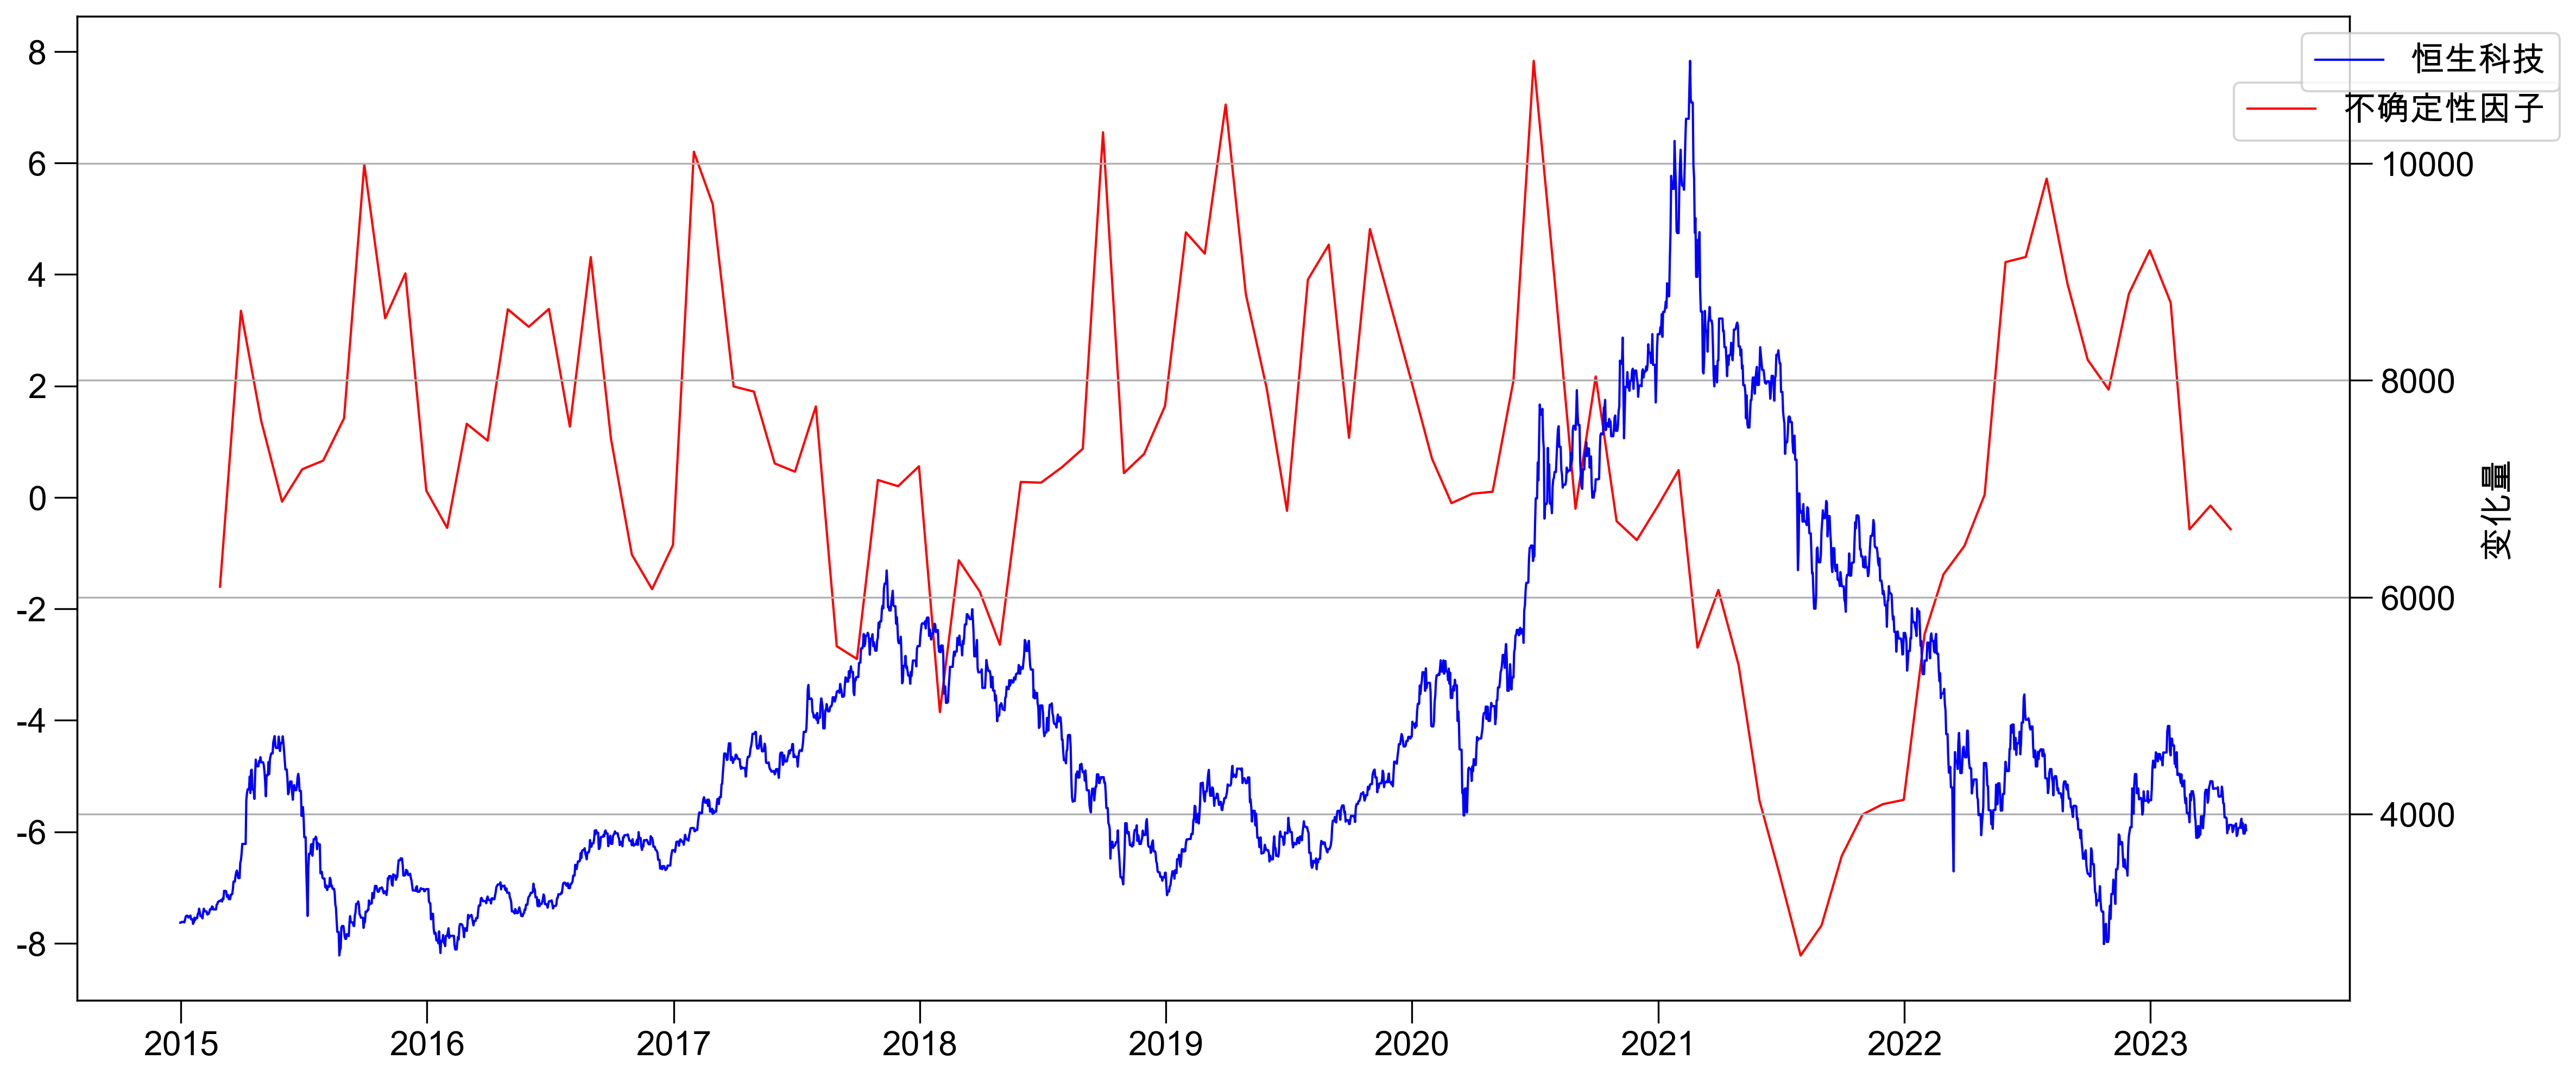

In [114]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
ax1=ax.twinx()   
ax.plot(data['日期'],data[0],
         linestyle='-',  linewidth=1,color ='red',label = '不确定性因子')
ax1.plot(y['日期'],y['恒生科技'],
         linestyle='-', linewidth=1,color = 'blue',label = '恒生科技')

plt.grid()
ax.legend(fontsize=15,loc=1,bbox_to_anchor=(1.1,0.95))
ax1.legend(fontsize=15,loc=1,bbox_to_anchor=(1.1,1.0))
plt.xlabel('start_date')
plt.ylabel('变化量')
#plt.ylim(0,150)
plt.savefig('图例.jpg')

In [66]:
y['恒生科技']

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
5251    3821.73
5252    3821.73
5253    3821.73
5254    3903.58
5255    3852.45
Name: 恒生科技, Length: 5256, dtype: float64

恒生中国


In [18]:
data_set = pd.merge(pd.DataFrame(y_copy['恒生中国企业指数'].dropna()),
                    X_copy,
                    left_index = True,
                    right_index = True)
meidian_for_all = pd.DataFrame()
for j in data_set.columns[1:]:

    list_total = []
    beta_list = []
    t_list = []
    r2_list = []
    for i in range(1000):
        random_seed = random.randint(0,len(data_set)-31)
        y = data_set.iloc[random_seed:random_seed+30]['恒生中国企业指数'].values.reshape(30,1)
        x = data_set.iloc[random_seed:random_seed+30][j].values.reshape(30,1)
        model = sm.OLS(y, x)
        res = model.fit()
        res = res.get_robustcov_results(cov_type='HAC',maxlags=1)
        beta = res.params[0]
        t = res.tvalues[0]
        r2 = res.rsquared
        beta_list.append(beta)
        t_list.append(t)
        r2_list.append(r2)
    list_total.append(np.median(beta_list))
    list_total.append(np.median(t_list))
    list_total.append(np.median(r2_list))
    list_total = pd.DataFrame(list_total).T
    list_total.columns = ['beta','t','r2']
    list_total.index = [j]
    meidian_for_all = meidian_for_all.append(list_total)  
hang_seng_china_index = meidian_for_all

In [19]:
# 打开一个 Excel 文件
work = pd.ExcelWriter('不确定因素.xlsx')

# 保存第一个表
hang_seng_china_index.to_excel(work, sheet_name='恒生中国')
hang_seng_index.to_excel(work, sheet_name='恒生指数')
hang_seng_technology_index.to_excel(work, sheet_name='科技指数')

# 数据持久化

work.save()




In [621]:
meidian_for_all[meidian_for_all['t'].transform(np.abs)>2]

,beta,t,r2
中国:固定资产投资完成额:基础设施建设投资:累计同比,0.326156,2.125789,0.112160
中国:销量:汽车:当月同比,0.388781,2.229664,0.160496
中国:商品房销售面积:累计同比,0.423202,3.466933,0.276139
中国:商品房销售额:累计同比,0.245306,2.862116,0.219866
中国:进出口金额:当月同比,0.676606,2.169264,0.193789
中国:出口金额:当月同比,1.007286,3.160662,0.381356


In [375]:
# %%time
# meidian_for_all = pd.DataFrame()
# for j in data_set.columns[1:]:

#     list_total = []
#     beta_list = []
#     t_list = []
#     r2_list = []
#     for i in range(1000):
#         random_seed = random.randint(0,len(data_set)-51)
#         model = FamaMacBeth(data_set.iloc[random_seed:random_seed+50]['恒生指数'].values.reshape(50,1)
#                             ,data_set.iloc[random_seed:random_seed+50][j].values.reshape(50,1))
#         res = model.fit(cov_type='kernel')
#         beta = res.params
#         t = res.tstats
#         r2 = res.rsquared
#         beta_list.append(beta.values[0])
#         t_list.append(t.values[0])
#         r2_list.append(r2)
#     list_total.append(np.median(beta_list))
#     list_total.append(np.median(t_list))
#     list_total.append(np.median(r2_list))
#     list_total = pd.DataFrame(list_total).T
#     list_total.columns = ['beta','t','r2']
#     list_total.index = [j]
#     meidian_for_all = meidian_for_all.append(list_total)

CPU times: user 10min 26s, sys: 3.4 s, total: 10min 30s
Wall time: 10min 30s


In [604]:
meidian_for_all.to_excel('new.xlsx')

In [611]:
meidian_for_all

,beta,t,r2
中国:GDP:不变价:当季同比,0.483637,2.714462,0.045946
中国:工业增加值:当月同比,0.434065,2.980749,0.054884
中国:PMI,0.027783,1.039007,0.007006
中国:PMI:生产,0.028510,1.108445,0.007966
中国:PMI:新订单,0.030706,1.165672,0.008803
中国:产量:发电量:当月同比,0.809935,4.347295,0.109942
中国:产量:水泥:当月同比,0.548851,3.605250,0.078301
中国:产量:粗钢:当月同比,0.926833,5.363390,0.158258
中国:产量:汽车:当月同比,0.404685,5.191718,0.149782
中国:铁路货运量:当月同比,0.550147,2.977450,0.054769
